# JSON examples and exercise
****
+ get familiar with packages for dealing with JSON
+ study examples with JSON strings and files 
+ work on exercise to be completed and submitted 

+ reference: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
+ data source: http://jsonstudio.com/resources/


## JSON example, with string

+ demonstrates creation of normalized dataframes (tables) from nested json string

http://pandas.pydata.org/pandas-docs/stable/io.html#normalization

## JSON example, with file

+ demonstrates reading in a json file as a string and as a table
+ uses small sample file containing data about projects funded by the World Bank 
+ data source: http://jsonstudio.com/resources/

(Not shown.)

****
## JSON exercise

Using data in file 'data/world_bank_projects.json' and the techniques demonstrated above,

**1. Find the 10 countries with most projects**

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

import json
from pandas.io.json import json_normalize

In [2]:
# Load json file into Python as dictionary
with open('data/world_bank_projects.json') as file:
     projects_json = json.load(file)

In [3]:
# Inspect JSON (print-out not shown because it is very long)
# print(json.dumps(projects_json[0], indent=5, sort_keys=True))

In [4]:
projects = json_normalize(projects_json, 'mjsector_namecode')  
print(projects.head()) 

  code                                     name
0   EX                                Education
1   EX                                Education
2   BX  Public Administration, Law, and Justice
3   EX                                Education
4   BX  Public Administration, Law, and Justice


In [5]:
# Read the JSON file into pandas and select the 2 variables of interest.
# (Since both are at the top level, we don't have to worry about the nested structure.)
df = pd.read_json('data/world_bank_projects.json')
projects = df.loc[:, ['countryshortname', 'project_name']]

# Count the number of projects per country and sort by descending count
projects_count = projects.groupby('countryshortname').count() \
                    .sort_values(by='project_name', ascending=False)

# Name the count column properly
projects_count = projects_count.rename(columns={'project_name': 'count'})

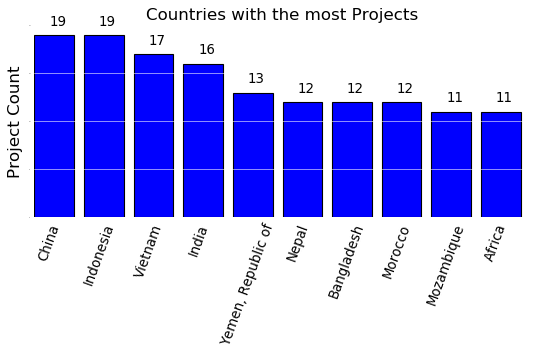

In [6]:
# Plot the 10 countries with the most projects
with plt.style.context('classic'): # Discard Seaborn defaults
    
    x = range(10) # x-axis position of countries
    ind = projects_count.index[:10] # Countries to plot ("index")
    counts = projects_count.iloc[:10,0].values # Project counts
    
    fig, ax = plt.subplots(figsize=(8, 3)) 
    ax.bar(x=x, height=counts, color='b')

    ax.set_title("Countries with the most Projects", fontsize=15)
    ax.set_ylabel("Project Count", fontsize=15)

    ax.set_xticks(np.arange(.3, 10.3, 1)) # center country label under each bar 
    ax.set_xticklabels(ind) # add country labels
    
    fig.patch.set_facecolor('w')  # Change background color to white  
    ax.grid(axis='y', color='white', linestyle='-') # white grid
    sns.despine(bottom=True, left=True) # Remove borders
    ax.tick_params(axis='x', length=0, labelsize=12, labelrotation=70)
    
    # Hide y-axes labels and add count to each bar
    ax.tick_params(axis='y', length=0, labelsize = 0) 
    for x_position, count in zip(x, counts):  
        plt.annotate(format(count, ','), xy=(x_position+.3, count+1))

plt.show()

The last row, "Africa", doesn't refer to an actual country, so let's take a closer look at those observations:

In [7]:
df.loc[df.countryshortname=='Africa', ['borrower']]

,borrower
45,ECOWAS
46,UGANDA-COMOROS
51,"OSS, IUCN, CILSS"
58,BANK EXECUTED
65,"BURUNDI,RWANDA,TANZANIA"
99,GOVERNMENT OF MALI
167,MINISTRIES OF TELECOM AND ICT
184,TANZANIA
287,"MALAWI, MOZAMBIQUE, ZAMBIA"
353,NILE BASIN INITIATIVE


It looks like at least some of those projects encompassed multiple countries.  Thus, the fact that "Africa" appears as one of the countries is not necessarily due to sloppy data entry.

**2. Find the top 10 major project themes (using column 'mjtheme_namecode')**

In [8]:
# Since the themes are not at the top level of the JSON file, we need to flatten the file.
themes = json_normalize(projects_json, 'mjtheme_namecode')

# Properly encode missing values (currently encoded as empty string)
themes.loc[themes.name=='','name'] = None

# Drops observations where the theme name is missing
themes_complete = themes.dropna(subset=['name'])

# Group by theme and count, then sort by descending order
themes_count = themes_complete.groupby('name').count() \
                  .sort_values(by='code', ascending=False)

# Properly name the counter column
themes_count = themes_count.rename(columns={'code': 'count'})

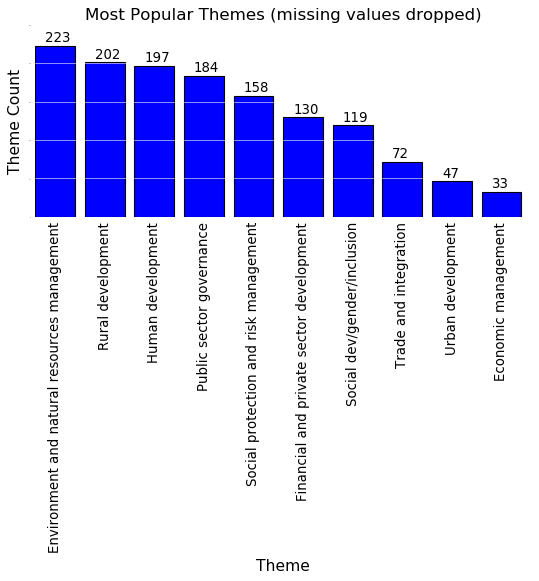

In [9]:
with plt.style.context('classic'): # Discard Seaborn defaults
    
    x = range(10) # x-axis position of themes
    ind = themes_count.index[:10] # Themes to plot ("index")
    counts = themes_count.iloc[:10,0].values # Themes counts
    
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.bar(x=x, height=counts, color='b')

    ax.set_title("Most Popular Themes (missing values dropped)", fontsize=15)
    ax.set_xlabel("Theme", fontsize=14)
    ax.set_ylabel("Theme Count", fontsize=14)

    ax.set_xticks(np.arange(.4, 10.4, 1)) # center theme label under each bar 
    ax.set_xticklabels(ind) # add theme labels
    
    fig.patch.set_facecolor('w')  # Change background color to white  
    ax.grid(axis='y', color='white', linestyle='-') # white grid
    sns.despine(bottom=True, left=True) # Remove borders
    # Rotate X-axes labels and remove ticks
    ax.tick_params(axis='x', length=0, labelsize=12, labelrotation=90)
    
    # Hide y-axes labels and add count to each bar
    ax.tick_params(axis='y', length=0, labelsize = 0) 
    for x_position, count in zip(x, counts):  
        plt.annotate(format(count, ','), xy=(x_position+.2, count+5))

plt.show()

**3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.**

To fill in the missing values for project name, we can rely on the fact that the project code does not contain any missing values. So all we need to do is to locate another observation with the same project code, then we can get the project name from it:

In [10]:
# First collect all the unique project codes for which at least one project name is missing
missing_codes = set(themes.loc[themes.name.isnull(), 'code'].values)

# For each of these codes, find the matching project name and store the result in a dictionary
themes_encoding = {}
for code in missing_codes:
    names = themes.loc[themes.code==code, 'name'] 
    # Select the first project name that is not missing
    for potential_name in names:
        if potential_name is None:
            continue
        else:
            themes_encoding[code] = potential_name

In [11]:
# Fill missing values
themes.loc[themes.name.isnull(), 'name'] = themes.code.apply(lambda code: themes_encoding[code])

# Make sure that there are no missing values anymore
assert(themes.isnull().sum().sum()==0)

# Take a look at data frame with the filled missing values
themes.head()

,code,name
0,8,Human development
1,11,Environment and natural resources management
2,1,Economic management
3,6,Social protection and risk management
4,5,Trade and integration
